In [1]:
import os
import sys
from pathlib import Path

curr_dir = Path(os.path.split(os.getcwd())[0])

api_dir = str(curr_dir)
if api_dir not in sys.path:
    sys.path.insert(0, api_dir)

import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from src.model.classifier import Classifier
from src.xbox2_specific.datasets.XBOX2_trend_all_bd_20ms import XBOX2TrendAllBD20msSelect
from src.utils.dataset_creator import load_dataset

2021-11-10 11:27:15.206627: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-10 11:27:15.206643: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Load Dataset
To load a dataset the dataset name and path to data has to be supplied.
This information is then passed to the `load_dataset` function which returns training, validation and test set.

For the xbox2 dataset some additional information is passed to the dataset loader.
First, the `manual_split` argument can be used to specify custom splitting of the data using run numbers.
Secondly, the `manual_scale` argument can be used to specify if scaling should
be done using mean and standard deviation of each run.

In [2]:
train_runs = [2, 4, 5, 6, 8, 9]
valid_runs = [1, 7]
test_runs = [3]

path_to_data = Path("/eos/project/m/ml-for-alarm-system/private/CLIC_data_transfert/Xbox2_hdf_new2/")

train, valid, test = load_dataset(creator=XBOX2TrendAllBD20msSelect(),
                                  data_path=path_to_data,
                                  manual_split=(train_runs, valid_runs, test_runs),
                                  manual_scale=[1, 2, 3, 4, 5, 6, 7, 8, 9])

2021-11-10 11:48:44.226863: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-10 11:48:44.252410: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-10 11:48:44.264727: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hsb-cern): /proc/driver/nvidia/version does not exist
2021-11-10 11:48:44.578682: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Plot Dataset
A good sanity check is to plot the data and checking if the data looks as expected.

In [5]:
n_features = len(train.X.feature)

fig, ax = plt.subplots(n_features,2, figsize=(20,60))
for i in range(n_features):
    ax[i, 0].plot(train.X[train.y.values.argmax(axis=1) == 0][:,:,i].values.T, alpha=0.3)
    ax[i, 0].set_xlabel("sample")
    ax[i, 0].set_ylabel(train.X.feature[i].values)
    ax[i, 0].set_xticks([0, 1, 2])
    ax[i, 1].plot(train.X[train.y.values.argmax(axis=1) == 1][:,:,i].values.T, alpha=0.3)
    ax[i, 1].set_xlabel("sample")
    ax[i, 1].set_xticks([0, 1, 2])
    bottom0, top0 = ax[i, 0].set_ylim()
    bottom1, top1 = ax[i, 1].set_ylim()
    ax[i, 0].set_ylim([min([bottom0, bottom1]), max([top0, top1])])
    ax[i, 1].set_ylim([min([bottom0, bottom1]), max([top0, top1])])

ax[0, 0].set_title("Healthy")
ax[0, 1].set_title("Breakdown in 20 ms")
fig.tight_layout()
plt.show()

# Getting data ready for machine learning
Before the data is sent to the machine learning models we need to convert them from xarray DataArrays into standard numpy arrays.
This can be done manually or using the helper function found in the dataset_creator module.

In [ ]:
from src.utils.dataset_creator import da_to_numpy_for_ml
train_numpy, valid_numpy, test_numpy = da_to_numpy_for_ml(train, valid, test)

# Create and Use Classifier Model
To create a classifier model an instance of the `Classifier` class is created.
To do this some hyperparameter settings are needed. These are loaded from a ´.json´ file.
We also need to pass the input shape and the directory to put model outputs.

In [ ]:
# Load hyperparameters into dictionary
hp_file = open(Path(api_dir) / "src/model/default_hyperparameters.json")
hp_dict = json.load(hp_file)

# Create model
clf = Classifier(input_shape=train_numpy.X.shape, output_directory=Path(api_dir) / "src/output", **hp_dict)

## Fit Model
After the model is created it has to be fitted to the data. This is done using the `fit_classifier` method.
Alternatively if a model already has been trained, the trained weights can be loaded.
It is faster to simply load pretrained weights as training is time-consuming.

In [ ]:
# Fit model to training set and validate on validation set
clf.fit_classifier(train_numpy, valid_numpy)
# load weights from an already trained model
# clf.model.load_weights(Path(api_dir) / "src/model/trained_models/trend_all_bd_20ms.hdf5")

## Make Prediction
When the model has been fitted to the data, it can be used to make predictions.
Here the prediction is done on the kept out test set using the `predict` method.

In [ ]:
y_pred = clf.model.predict(x=test_numpy.X)
y_pred

## Evaluate Model
To evaluate the performance of the model, the `evaluate` method can be used.

In [8]:
# eval classifier
results = clf.model.evaluate(x=test_numpy.X, y=test_numpy.y, return_dict=True)
pd.DataFrame.from_dict(results, orient='index').T

21/21 [==============================] - 0s 2ms/step - loss: 0.5697 - tp: 636.0000 - fp: 17.0000 - tn: 636.0000 - fn: 17.0000 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - auc: 0.9797 - prc: 0.9738    


,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc
0,0.569676,636.0,17.0,636.0,17.0,0.973966,0.973966,0.973966,0.979728,0.973786


# Explanation
After training the model we now wish to explain the predictions of the model.
This can be done using explainers such as the SHAP gradient explainer.

## Make prediction
To explain a prediction we first make predictions on the test set

In [9]:
y_pred = clf.model.predict(x=test_numpy.X)

We then use `explain_samples` to explain the samples.
In this example we use the SHAP gradient explainer.

In [10]:
from src.model.explainer import explain_samples
from src.model.sample_explainers.gradient_shap import ShapGradientExplainer

is_correct_classification = (y_pred.argmax(axis=1) == test_numpy.y.argmax(axis=1))
ex_classification = explain_samples(explainer=ShapGradientExplainer(),
                                    model=clf.model,
                                    X_reference=train_numpy.X,
                                    X_to_explain=test_numpy.X[is_correct_classification, :, :])

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


## Visualization of explanations
To explain which features are most important for the explanation, 
we can take the global mean of the shap values for each feature. 
To visualize the explanation we can plot this in a barplot. 

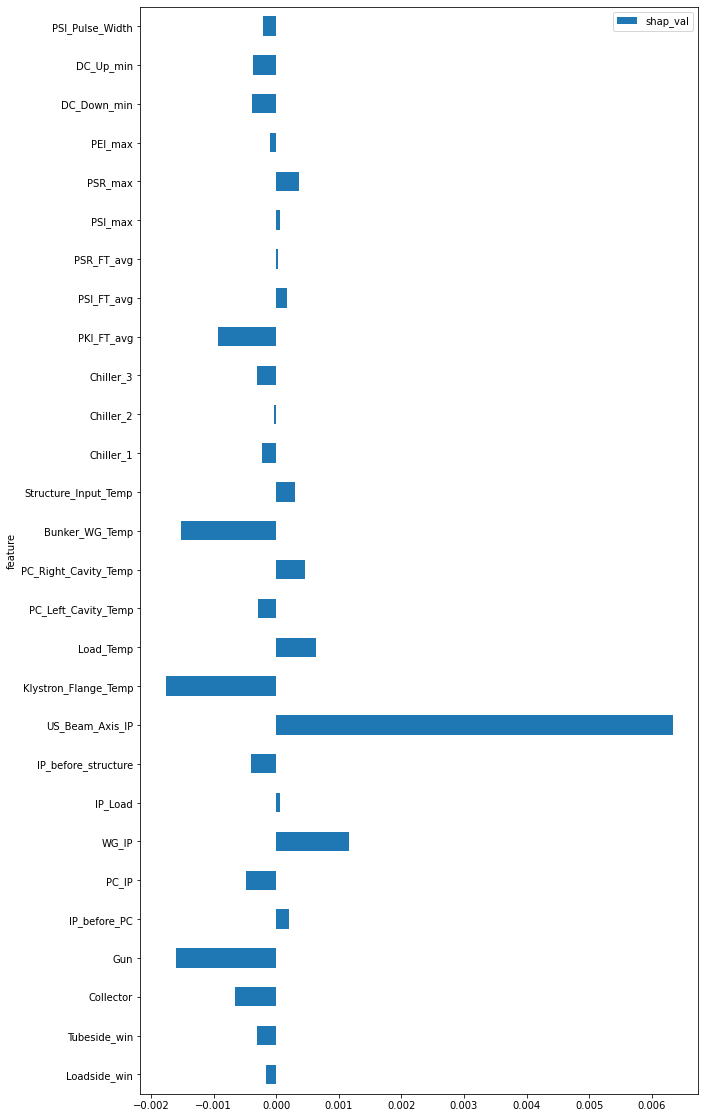

In [12]:
import numpy as np
import pandas as pd
ex_global = np.mean(np.mean(ex_classification[1], axis=0), axis=0)
df = pd.DataFrame({'feature': test.X.feature.values, 'shap_val': ex_global})
ax = df.plot.barh(x='feature', y='shap_val', figsize=(10,20))


In order to present the sample explanation we can make a plot of the signal with a coloured overlay.
Here, overlay color is determined by the shap value.

In [ ]:
def plot_importance(X_to_explain, y_pred, explanation):
    cmap = mpl.colors.LinearSegmentedColormap.from_list('shap', [mpl.cm.cool(0), (1, 1, 1, 1), mpl.cm.cool(256)],N=256)

    fig, ax = plt.subplots(figsize=(7,5))
    ax.plot(X_to_explain[(y_pred.argmax(axis=1) == 0), :, :].mean(axis=0), linewidth=3, c="b")
    ax.plot(X_to_explain[(y_pred.argmax(axis=1) == 1), :, :].mean(axis=0), linewidth=3, c="r")

    extent = [0, len(X_to_explain[0]), ax.get_ylim()[0], ax.get_ylim()[1]]
    im1 = ax.imshow(explanation[0].mean(axis=0).T, cmap=cmap, aspect="auto", alpha=0.8, extent=extent)
    cbar1 = fig.colorbar(im1, ax=ax)
    cbar1.set_label("SHAP values (relative)")

    ax.set_xlabel("samples")
    ax.set_xlabel("amplitude")
    ax.set_title("Explanations of Classifications")
    ax.legend(["Mean normal","Mean ischemia"])